In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from matplotlib_venn import venn3
from scipy.stats import shapiro
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
path = "../data/Time Management and Productivity Insights.csv"
data = pd.read_csv(path)
data.sample(5)

,User ID,Age,Daily Work Hours,Daily Leisure Hours,Daily Exercise Minutes,Daily Sleep Hours,Productivity Score,Screen Time (hours),Commute Time (hours)
49,50,41,5.6,5.0,88,7.5,80,5.9,2.2
82,83,40,9.3,4.1,65,7.2,94,7.3,1.4
44,45,18,6.4,5.0,35,7.4,74,4.6,1.6
50,51,35,8.7,3.5,55,6.9,92,7.6,0.9
62,63,36,8.1,3.9,95,6.9,89,7.8,2.5


In [3]:
data.describe()

,User ID,Age,Daily Work Hours,Daily Leisure Hours,Daily Exercise Minutes,Daily Sleep Hours,Productivity Score,Screen Time (hours),Commute Time (hours)
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,43.000000,39.529412,7.021176,4.264706,64.611765,7.111765,82.176471,5.774118,1.584706
std,24.681302,12.416951,1.523396,1.157348,27.006654,0.783523,10.250640,1.225343,0.534190
min,1.000000,18.000000,3.400000,1.700000,6.000000,5.200000,55.000000,2.800000,0.600000
25%,22.000000,29.000000,5.900000,3.400000,45.000000,6.600000,74.000000,4.900000,1.200000
50%,43.000000,39.000000,7.100000,4.300000,65.000000,7.100000,85.000000,5.900000,1.600000
75%,64.000000,50.000000,8.200000,5.100000,88.000000,7.700000,90.000000,6.900000,2.000000
max,85.000000,63.000000,9.500000,6.400000,120.000000,8.800000,95.000000,7.800000,2.500000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 85 non-null     int64  
 1   Age                     85 non-null     int64  
 2   Daily Work Hours        85 non-null     float64
 3   Daily Leisure Hours     85 non-null     float64
 4   Daily Exercise Minutes  85 non-null     int64  
 5   Daily Sleep Hours       85 non-null     float64
 6   Productivity Score      85 non-null     int64  
 7   Screen Time (hours)     85 non-null     float64
 8   Commute Time (hours)    85 non-null     float64
dtypes: float64(5), int64(4)
memory usage: 6.1 KB


# Preprocessing

In [5]:
features = data.drop('User ID', axis=1)
X = features.values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means Clustering

In [6]:
wcss = []
bcss = []
max_clusters = 5
k_range = range(1, max_clusters + 1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # WCSS
    bcss.append(np.sum((kmeans.cluster_centers_ - np.mean(X_scaled, axis=0))**2))  # BCSS

c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [7]:
# Calculate TSS and the ratio BCSS / (BCSS + WCSS)
tss = np.array(wcss) + np.array(bcss)
ratio = bcss / tss

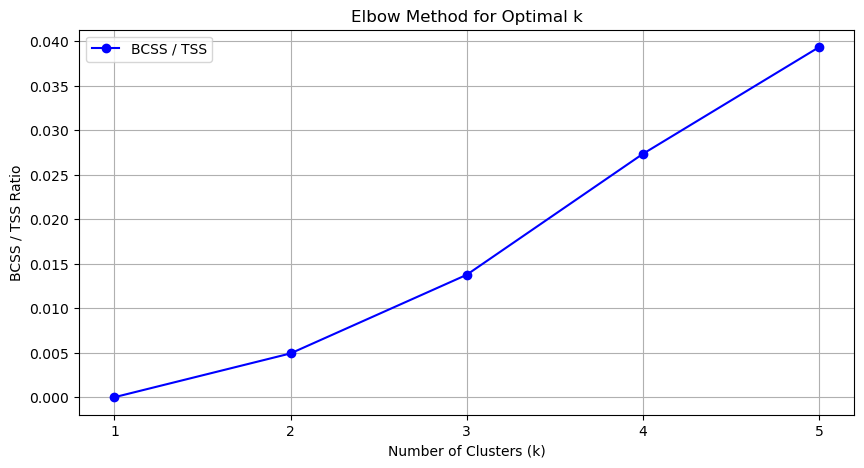

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(k_range, ratio, 'bo-', label='BCSS / TSS')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('BCSS / TSS Ratio')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid()
plt.legend()
plt.show()

In [9]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
data['Cluster'] = clusters

c:\Users\dsta0\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


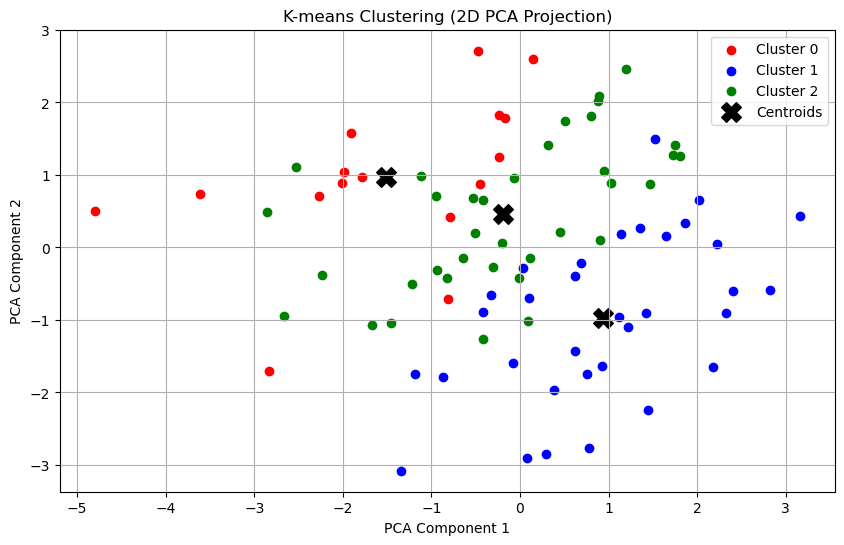

In [10]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']  # Adjust for k
for i in range(k):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1], 
                c=colors[i], label=f'Cluster {i}')

# Plot centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            marker='X', s=200, c='black', label='Centroids')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-means Clustering (2D PCA Projection)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(data.groupby('Cluster').mean())